#### 5

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006      
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,0,1)
var_sarpdq   <-  c(1,0,1)
var_drift   <-  TRUE
var_constant   <-  TRUE

var_char  <-  c(4,2)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=19, end=46)
# gts_test  <- window(y, start=47, end=54)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22396.4572   -662.7842   -921.6093   1761.5075   -959.0668  11068.7190
 [7]  20426.6376  24437.7897  22965.5331  18413.8115  13276.7779  10269.1680
[13]  -8873.5836  10997.4340   9555.8300  10959.9995   8023.5553  19801.2976
[19]  29108.7860  33148.9488  31686.8943  27147.7514  22035.4260  19040.2109
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13 

Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -17188.8570 -10176.1983  -8173.0506  -5001.6635   6526.3136  17593.2035
 [7]  20173.9123  11835.6362   6815.0751   2769.0371  -3420.4923 -28219.1123
[13]  -9068.2268  -3366.1174  -2353.6606   -323.8651   9611.9687  19019.1824
[19]  21109.5661  13720.0603   9215.1771   5623.2066    185.1779 -21628.6153
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -17286.07368 -10237.91378  -8232.42859  -5083.57906   6499.01120
 [6]  17582.33834  20156.11907  11818.83724   6764.47120   2724.94852
[11]  -3487.82192 -28380.30437  -9188.97749  -3437.07474  -2426.28114
[16]   -382.52187   9593.33373  19013.69982  21101.94286  13692.53889
[21]   9154.82979   5573.05919     92.90156 -21804.51124

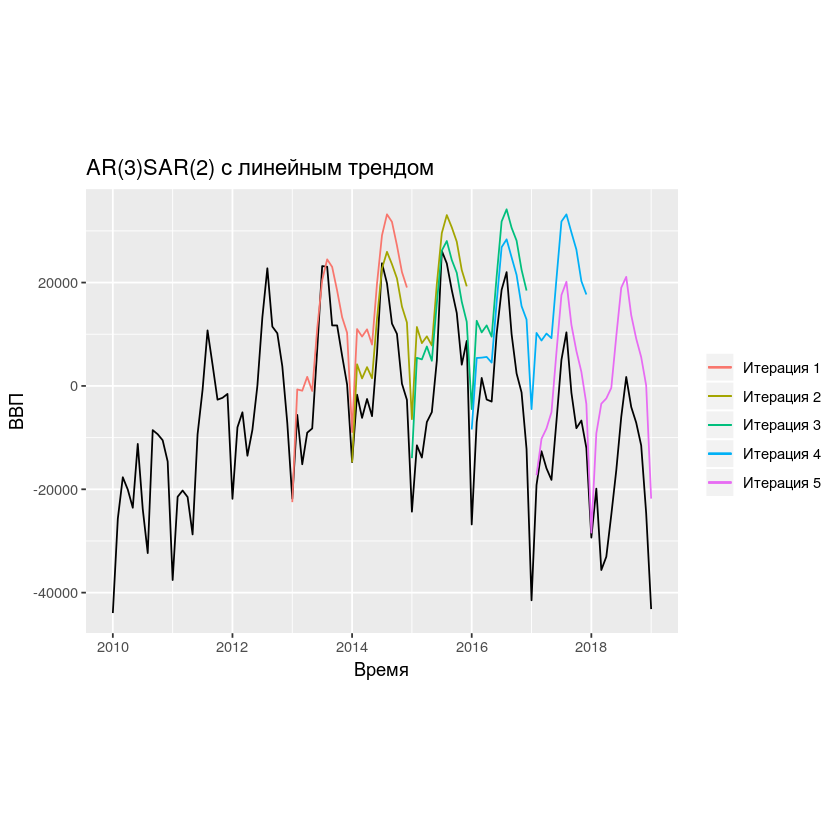

In [13]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [14]:
df_acc

ME,RMSE,MAPE,Iteration
-10358.94,12198.66,530.7762,1
-11069.06,12650.28,297.9639,13
-13770.96,15574.88,289.2476,25
-20300.10,22493.37,373.3069,37
-15618.03,17769.55,211.8987,50


In [15]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-14223.4163  16137.3468    340.6387     25.2000

In [16]:
df_mean_acc <- readRDS("df_mean_acc.rds")
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.9760,16758.99
3 level,64.27635,376.7024,NA
2 level (state),64.91149,376.7413,NA
2 level (type),65.23056,375.7386,NA
2 level (clusetered),65.07266,375.0489,NA


In [17]:
df_mean_acc[2,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.9760,16758.99
3 level,64.27635,376.7024,16137.35
2 level (state),64.91149,376.7413,NA
2 level (type),65.23056,375.7386,NA
2 level (clusetered),65.07266,375.0489,NA


In [18]:
df_acc

ME,RMSE,MAPE,Iteration
-10358.94,12198.66,530.7762,1
-11069.06,12650.28,297.9639,13
-13770.96,15574.88,289.2476,25
-20300.10,22493.37,373.3069,37
-15618.03,17769.55,211.8987,50


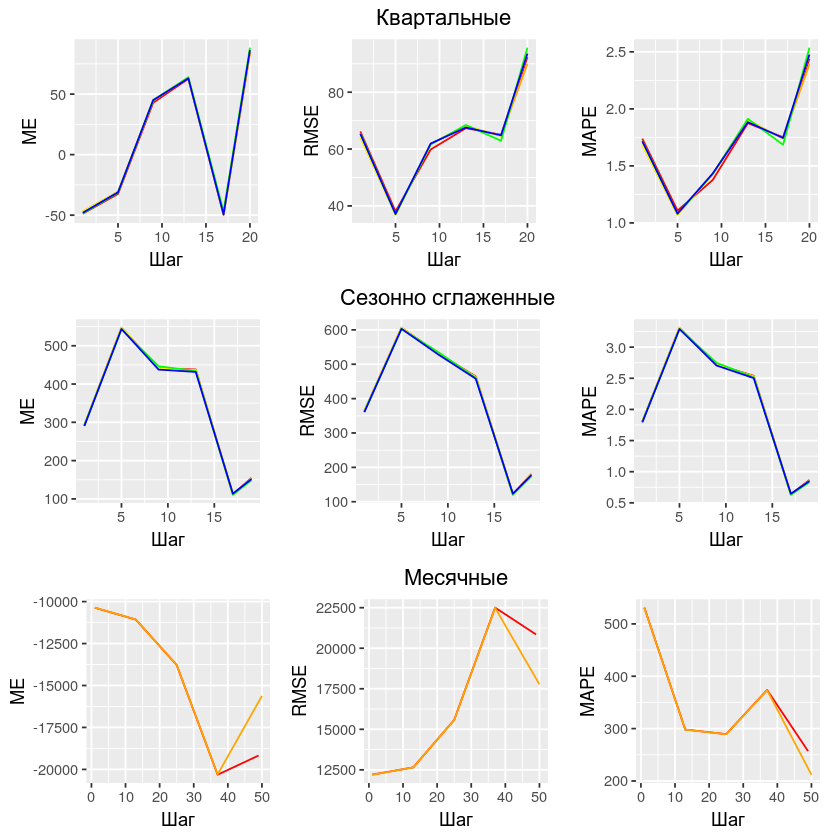

In [19]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [20]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [21]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [22]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [23]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22433.4634   -658.5730   -912.0200   1763.8633   -959.4648  11082.1600
 [7]  20434.1288  24459.2177  22990.1297  18417.8599  13286.6751  10278.6414
[13]  -8901.3109  11001.1807   9558.3470  10957.7529   8018.0263  19805.3254
[19]  29121.6285  33168.0093  31705.5998  27156.5964  22038.0040  19040.1654
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 12

Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14747.912   4183.786   1462.003   3646.028   1503.191  12997.086
 [7]  22718.708  25935.104  23535.091  20798.450  15363.243  12273.009
[13]  -6392.698  11408.221   8295.157   9604.624   7851.594  19683.563
[19]  29562.654  33043.958  30677.658  27894.754  22425.936  19269.884
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -13922.931   5452.352   5144.834   7638.420   4879.659  16013.056
 [7]  26160.102  28017.822  24354.346  21870.404  16306.160  12410.171
[13]  -4433.023  12618.185  10375.092  11722.964   9554.234  21160.159
[19]  31790.647  34151.609  30589.297  28097.131  22479.024  18465.080
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -8422.766  5399.382  5460.977  5607.580  4520.383 16152.494 26823.791
 [8] 28334.946 24861.411 21453.787 15436.000 12841.152 -4448.384 10256.411
[15]  8788.622 10135.941  9251.330 20694.897 31782.860 33157.618 29681.707
[22] 26352.771 20263.716 17689.597
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -17217.4623 -10177.9706  -8173.5425  -5024.6341   6530.8146  17585.5818
 [7]  20162.3049  11838.9191   6798.8692   2762.3218  -3430.0122 -28256.6864
[13]  -9090.7246  -3373.8060  -2363.2098   -335.0605   9613.5337  19012.5478
[19]  21105.3548  13719.6248   9200.1698   5618.5333    167.6754 -21667.0384
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [24]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [25]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [26]:
df_acc

ME,RMSE,MAPE,Iteration
-10363.35,12203.81,531.0067,1
-11073.17,12654.03,298.1448,13
-13779.70,15582.22,289.4048,25
-20307.59,22498.78,373.5134,37
-15606.71,17760.72,211.8270,50


In [27]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -17286.07368 -10237.91378  -8232.42859  -5083.57906   6499.01120
 [6]  17582.33834  20156.11907  11818.83724   6764.47120   2724.94852
[11]  -3487.82192 -28380.30437  -9188.97749  -3437.07474  -2426.28114
[16]   -382.52187   9593.33373  19013.69982  21101.94286  13692.53889
[21]   9154.82979   5573.05919     92.90156 -21804.51124

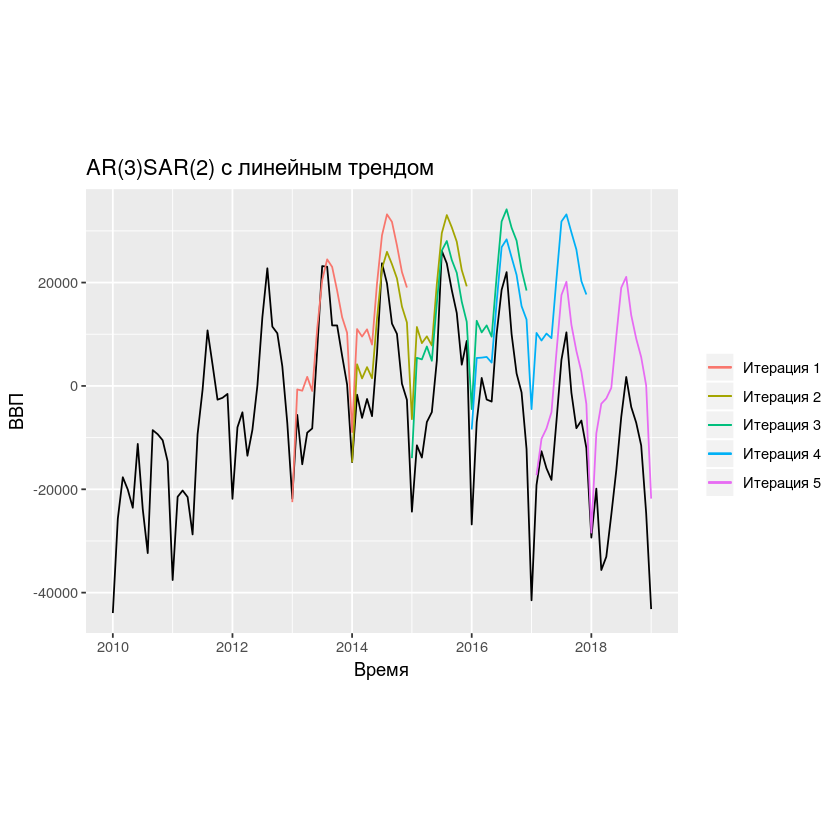

In [28]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [29]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-14226.1058  16139.9138    340.7793     25.2000

In [30]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [31]:
df_mean_acc[3,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.9760,16758.99
3 level,64.27635,376.7024,16137.35
2 level (state),64.91149,376.7413,16139.91
2 level (type),65.23056,375.7386,NA
2 level (clusetered),65.07266,375.0489,NA


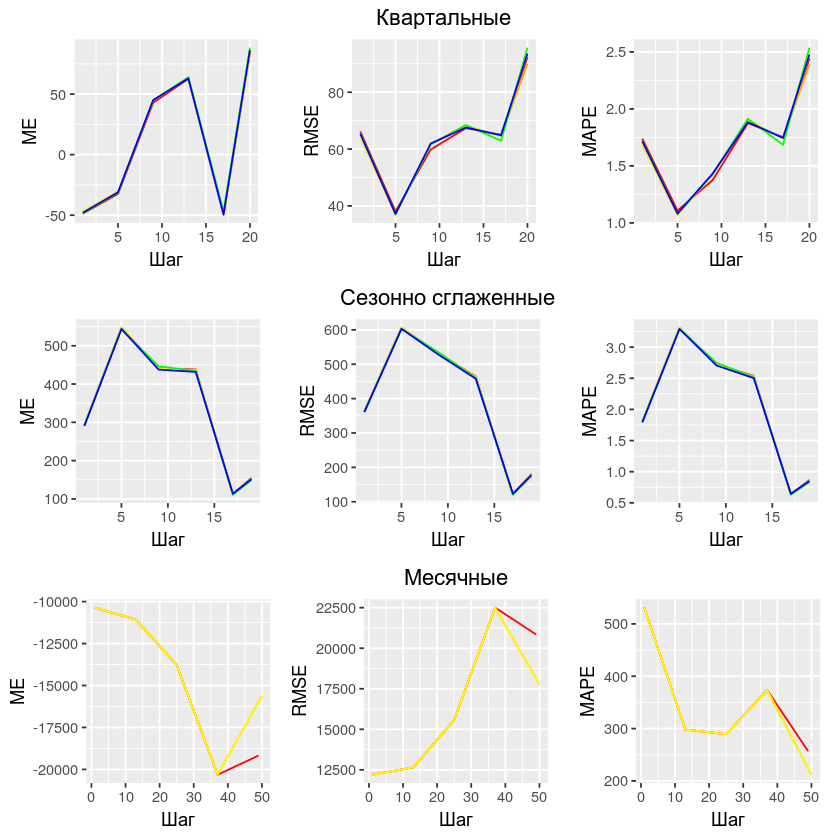

In [32]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [33]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_type.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [34]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [35]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [36]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -19356.8440    461.8350  -1172.1739   2548.3553    571.7889  11661.6948
 [7]  20771.9466  23435.3094  22161.4018  19851.9860  13560.9740   9607.2419
[13]  -5657.7492  11866.2057   9545.1879  12646.5013   9270.1702  20829.2848
[19]  28587.6322  31634.4158  31555.0164  27348.6816  22997.4474  19377.9451
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -13742.1180   3067.6600   -370.2637   3346.4564   1081.9597  12417.2668
 [7]  23067.0639  25269.4529  22786.3505  21168.2168  14975.9373  11665.3314
[13]  -5086.9287  11071.7219   7203.1918  10000.7261   8050.9314  19459.2188
[19]  29402.9559  32242.3225  29895.4056  27828.4751  22416.0970  18649.6092
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14375.709   4714.294   3296.121   6836.698   4599.476  15058.581
 [7]  25929.861  26630.593  24014.927  20742.376  14645.209  11930.458
[13]  -5198.799  11962.448   9149.454  11135.711   9775.298  20499.038
[19]  30984.442  32674.890  29911.663  26653.046  21210.300  17859.212
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -9805.278  4142.204  4179.959  4279.391  3884.257 15541.298 26466.310
 [8] 27676.344 24444.183 20468.179 14399.534 12546.787 -5383.389  9489.193
[15]  7669.310  9278.952  8927.688 19929.161 31548.678 32386.852 29006.997
[22] 25534.992 19181.488 17333.788
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -15063.0944 -10509.2528  -8187.4283  -3638.5580   4827.2678  17875.6293
 [7]  20463.4150   9992.6877   7273.2527   2114.7106  -4432.5266 -27136.5252
[13]  -8421.8534  -3885.6457  -1921.9879   -162.3154   8379.5300  19256.9834
[19]  20630.4531  12413.8643   9393.3032   4582.8301   -167.7926 -20520.1741
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [37]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [38]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [39]:
df_acc

ME,RMSE,MAPE,Iteration
-10933.59,12617.90,539.7692,1
-10776.25,12405.73,287.6536,13
-12935.73,14795.22,272.0747,25
-19518.04,21822.76,355.0013,37
-15529.66,17614.81,202.9775,50


In [40]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -17286.07368 -10237.91378  -8232.42859  -5083.57906   6499.01120
 [6]  17582.33834  20156.11907  11818.83724   6764.47120   2724.94852
[11]  -3487.82192 -28380.30437  -9188.97749  -3437.07474  -2426.28114
[16]   -382.52187   9593.33373  19013.69982  21101.94286  13692.53889
[21]   9154.82979   5573.05919     92.90156 -21804.51124

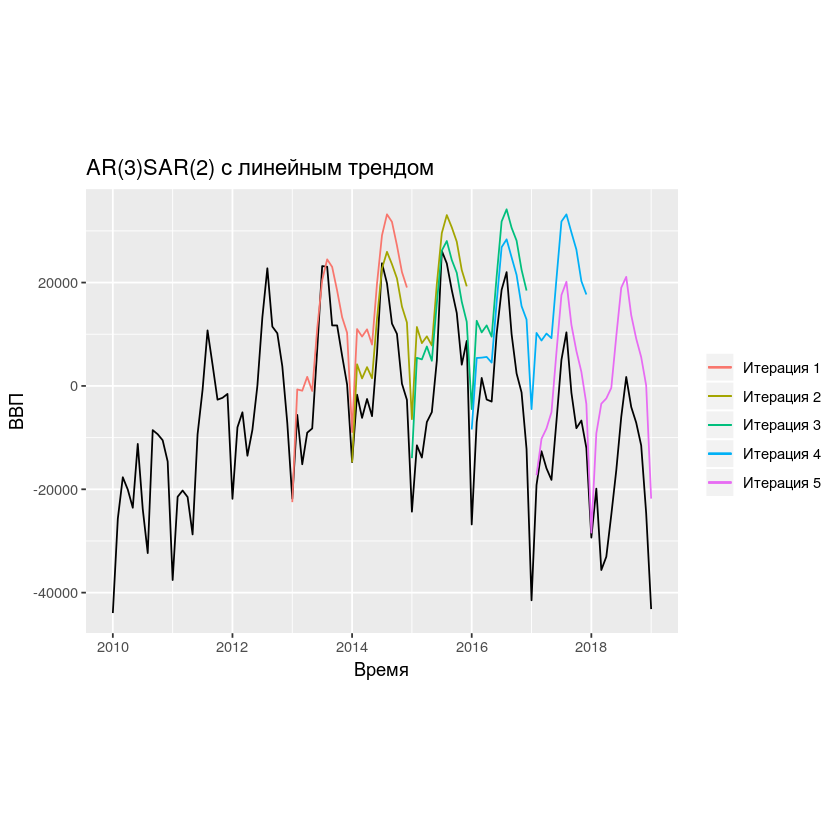

In [41]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [42]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-13938.6544  15851.2841    331.4953     25.2000

In [43]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [44]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.9760,16758.99
3 level,64.27635,376.7024,16137.35
2 level (state),64.91149,376.7413,16139.91
2 level (type),65.23056,375.7386,NA
2 level (clusetered),65.07266,375.0489,NA


In [45]:
df_mean_acc[4,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.9760,16758.99
3 level,64.27635,376.7024,16137.35
2 level (state),64.91149,376.7413,16139.91
2 level (type),65.23056,375.7386,15851.28
2 level (clusetered),65.07266,375.0489,NA


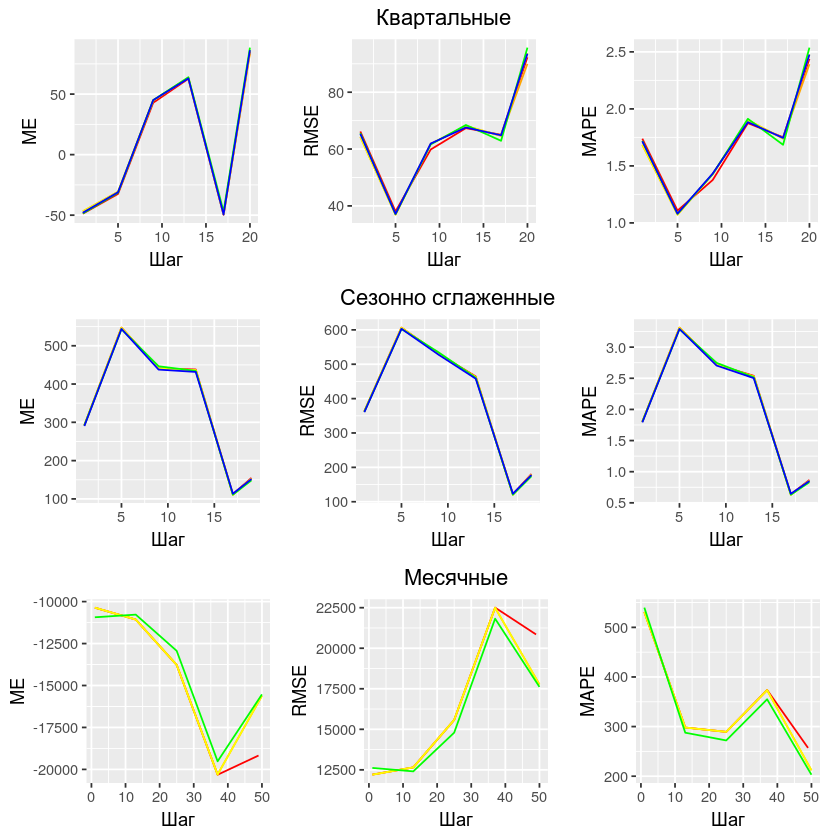

In [46]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [47]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_clust.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [48]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [49]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [50]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21937.2474   -441.1992   -981.4348   1864.8219   -707.8580  11128.9949
 [7]  20514.0819  24338.6217  22797.3133  18684.5758  13335.7253  10146.5972
[13]  -8356.3091  11163.3558   9547.9607  11228.6882   8236.0426  19965.2866
[19]  29066.7707  32959.5632  31652.3131  27207.7505  22213.2512  19101.7740
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 12

Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14627.880   3905.192   1171.100   3513.770   1277.693  12867.619
 [7]  22690.137  25738.393  23401.234  20720.730  15169.307  12138.385
[13]  -6369.596  11208.923   8118.127   9498.528   7757.996  19608.165
[19]  29443.990  32879.090  30512.273  27757.262  22325.510  19127.709
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14014.207   5263.891   4874.781   7465.867   4733.842  15860.595
 [7]  26038.832  27737.091  24269.961  21617.805  15995.495  12262.410
[13]  -4658.566  12443.661  10132.791  11526.870   9487.768  20985.534
[19]  31557.411  33871.372  30406.366  27811.351  22258.485  18280.692
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -8695.027  5191.601  5215.366  5352.441  4390.841 16029.507 26754.434
 [8] 28186.232 24786.536 21284.364 15246.034 12789.812 -4623.576 10136.205
[15]  8579.177 10007.019  9201.337 20583.863 31777.493 33019.899 29601.467
[22] 26246.816 20097.975 17661.399
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -1.692525e+04 -1.030101e+04 -8.264017e+03 -4.880220e+03  6.224385e+03
 [6]  1.755361e+04  2.016512e+04  1.151154e+04  6.768180e+03  2.594381e+03
[11] -3.651993e+03 -2.815300e+04 -9.063413e+03 -3.536323e+03 -2.398638e+03
[16] -3.871213e+02  9.355805e+03  1.894645e+04  2.097043e+04  1.344123e+04
[21]  9.099064e+03  5.366324e+03  9.261793e-01 -2.160088e+04
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [51]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [52]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [53]:
df_acc

ME,RMSE,MAPE,Iteration
-10459.64,12263.36,532.1535,1
-10941.53,12532.61,294.0347,13
-13584.50,15401.73,285.6298,25
-20171.97,22388.45,370.3306,37
-15516.27,17660.26,209.5113,50


In [54]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -17286.07368 -10237.91378  -8232.42859  -5083.57906   6499.01120
 [6]  17582.33834  20156.11907  11818.83724   6764.47120   2724.94852
[11]  -3487.82192 -28380.30437  -9188.97749  -3437.07474  -2426.28114
[16]   -382.52187   9593.33373  19013.69982  21101.94286  13692.53889
[21]   9154.82979   5573.05919     92.90156 -21804.51124

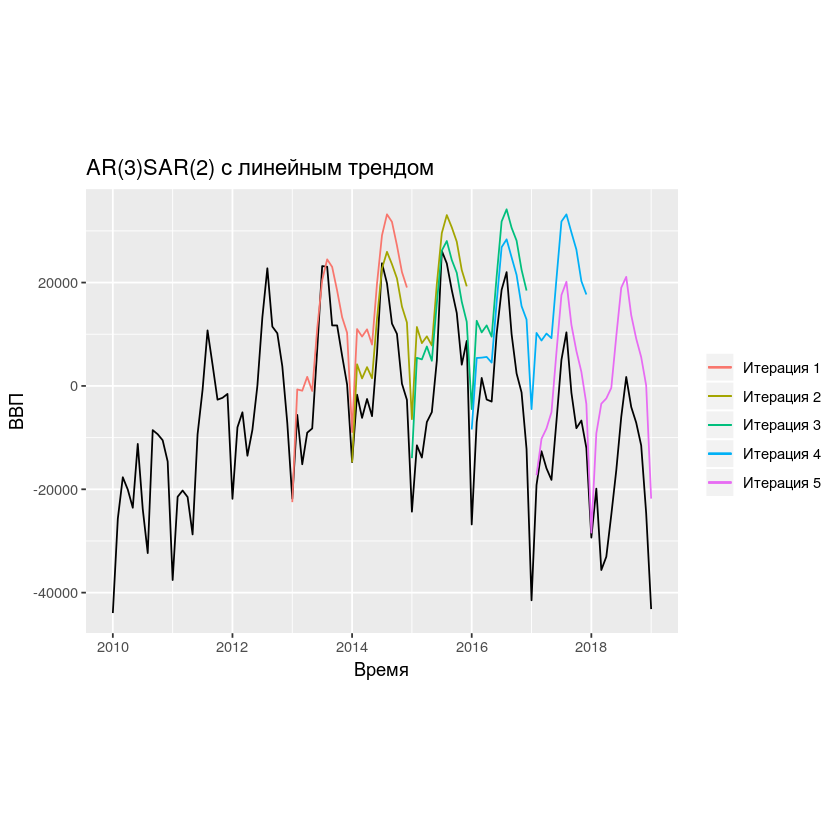

In [55]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [56]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-14134.783  16049.281    338.332     25.200

In [57]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [58]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.9760,16758.99
3 level,64.27635,376.7024,16137.35
2 level (state),64.91149,376.7413,16139.91
2 level (type),65.23056,375.7386,15851.28
2 level (clusetered),65.07266,375.0489,NA


In [59]:
df_mean_acc[5,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.9760,16758.99
3 level,64.27635,376.7024,16137.35
2 level (state),64.91149,376.7413,16139.91
2 level (type),65.23056,375.7386,15851.28
2 level (clusetered),65.07266,375.0489,16049.28


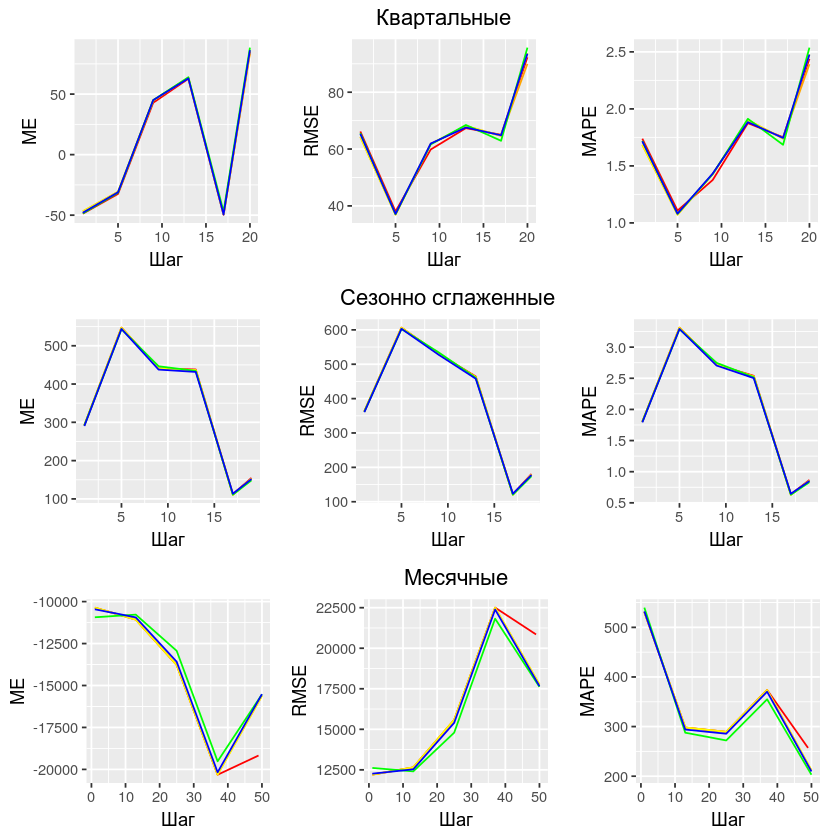

In [60]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [61]:
saveRDS(df_mean_acc, "df_mean_acc.rds")
saveRDS(plots_test_all, "plots_test_not_all.rds")